# Outbrain Click Prediction

### Project 3 - 158.333

#### Created by Francis Tang (15053399) and Masum Billah (16389498).

References:
- Lecture Notes from 158.333
- Lecture Notes from 158.222
- Code Snippets & functions from Kernels@Kaggle
- PySpark offical Documentation

## I. Import Libraries and Data Loading

### Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series,DataFrame
%matplotlib inline

In [2]:
filedir = '../datasets/'

import datetime
import time
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn import svm
from sklearn import metrics
from sklearn import neighbors
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

N_ROWS = 1000000

### Check & Load Data

In [3]:
# Checking the all the file and file size 
p = sns.color_palette()
print('# File sizes')
for f in os.listdir('../datasets'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../datasets/' + f) / 1000000, 2)) + 'MB')

# File sizes
clicks_test.csv               506.0MB
clicks_test.h5                831.0MB
clicks_train.csv              1486.0MB
documents_categories.csv      118.0MB
documents_entities.csv        324.0MB
documents_meta.csv            89.0MB
documents_topics.csv          339.0MB
events.csv                    1208.0MB
page_views_sample.csv         454.0MB
page_views_sample_geo.csv     13.0MB
promoted_content.csv          13.0MB
sample_submission.csv         273.0MB


Wow, that's a lot of data! Let's start off by looking at the clicks_train.csv and clicks_test.csv files, may be those two files contain the main things we need.

Each display has a certain number of adverts. Let's look at the distribution of these advert counts, and see if they are consistent between train and test.

In [5]:
df_train = pd.read_csv('../datasets/clicks_train.csv')
df_test = pd.read_csv('../datasets/clicks_test.csv')

## II. EDA

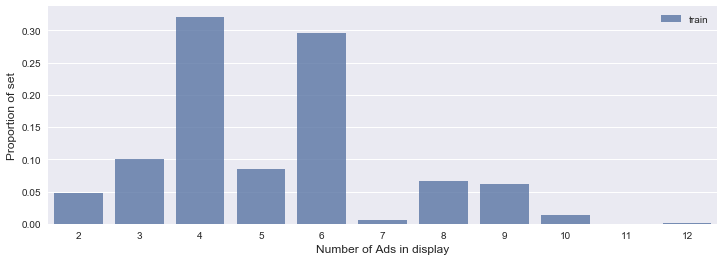

In [6]:
sizes_train = df_train.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')

plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

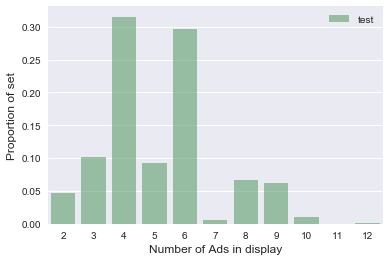

In [8]:
sizes_test = df_test.groupby('display_id')['ad_id'].count().value_counts()
sizes_test = sizes_test / np.sum(sizes_test)
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

This looks like a perfect split to me! So we can assume the distribution to be the same within the sets - no weird trickery going on here.

What about adverts? How many adverts are there that are very often used, and how many are rare?

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


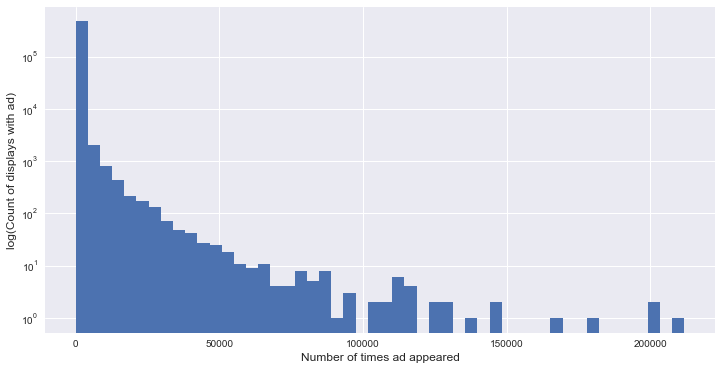

In [9]:
ad_usage_train = df_train.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

**Here we can see that a huge number of ads appear just a few times in the training set (so much that we have to use a log graph to show it), with two-thirds having less than 10 appearances. This shows us that we have to be able to predict whether someone will click on an ad not just based on the past data of that specific ad, but also by linking it to other adverts. **


**Now we will see documents categories VS how many times it occurs**

('Columns:', ['document_id', 'category_id', 'confidence_level'])
('Number of unique categories:', 97)
Number of categories that appear more than 1000 times: 88
Number of categories that appear more than 10000 times: 65
Number of categories that appear more than 50000 times: 35
Number of categories that appear more than 100000 times: 15


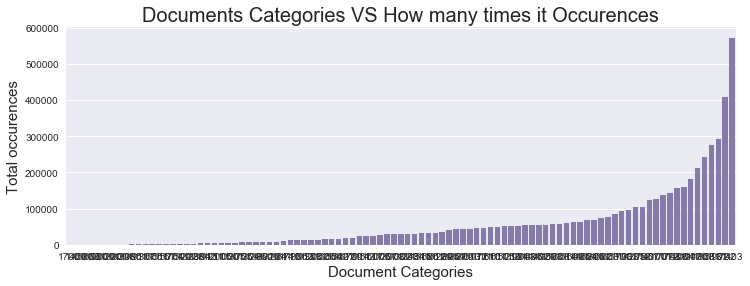

In [10]:
cat = pd.read_csv('../datasets/documents_categories.csv')
print('Columns:', cat.columns.tolist())
print('Number of unique categories:', len(cat.category_id.unique()))

cat_ids = cat.groupby('category_id')['confidence_level'].count().sort_values()

for i in [1000, 10000, 50000, 100000]:
    print('Number of categories that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
plt.title('Documents Categories VS How many times it Occurences', fontsize=20)
plt.xlabel('Document Categories', fontsize=15)
plt.ylabel('Total occurences', fontsize=15)
plt.show()

** Here we can see that, Number of unique categories: 97, Number of categories that appear more than 1000 times: 88, Number of categories that appear more than 10000 times: 65 ,  Number of categories that appear more than 50000 times: 35, Number of categories that appear more than 100000 times: 15**



**Now we will see Documents Topic VS How many times it occurs**

Number of topics that appear more than 10000 times: 201
Number of topics that appear more than 50000 times: 86
Number of topics that appear more than 100000 times: 22
Number of topics that appear more than 200000 times: 3


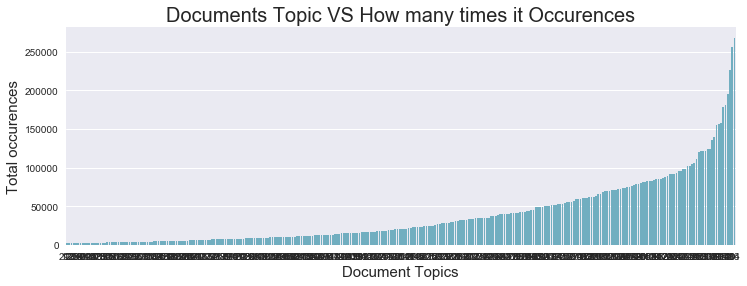

In [11]:
topics = pd.read_csv('../datasets/documents_topics.csv')
topic_ids = topics.groupby('topic_id')['confidence_level'].count().sort_values()

for i in [10000, 50000, 100000, 200000]:
    print('Number of topics that appear more than {} times: {}'
          .format(i, (topic_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(topic_ids.index, topic_ids.values, order=topic_ids.index, alpha=1, color=p[5])
plt.title('Documents Topic VS How many times it Occurences', fontsize=20)
plt.xlabel('Document Topics', fontsize=15)
plt.ylabel('Total occurences', fontsize=15)
plt.show()

** Number of topics that appear more than 10000 times: 201, Number of topics that appear more than 50000 times: 86 Number of , topics that appear more than 100000 times: 22, Number of topics that appear more than 200000 times: 3 **

## III. Data Wrangling

Now we will marge the document data to promoted content, and explore some more features.

In [ ]:
from subprocess import check_output
#print(check_output(["ls", "../datasets"]).decode("utf8"))

In [12]:
# Checking the data set called documents_categories.csv
documents_cat = pd.read_csv('../datasets/documents_categories.csv').rename(columns={'confidence_level': 'category_confidence_level'})
documents_cat.head(7)

,document_id,category_id,category_confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92
3,1524246,1608,0.07
4,1617787,1807,0.92
5,1617787,1608,0.07
6,1615583,1305,0.92


In [13]:
# Checking the data set called documents_entities.csv
documents_ent = pd.read_csv('../datasets/documents_entities.csv').rename(columns={'confidence_level': 'entity_confidence_level'})
documents_ent.tail()

,document_id,entity_id,entity_confidence_level
5537547,1291726,346d9349f96af98c8a5092b0f6d6d952,0.297644
5537548,1291726,ea1da4c578e07a535e410a30eb1cc44a,0.295476
5537549,1855422,896ebce354e38fd15e1097336c97e030,0.882060
5537550,1855422,d6cd68db952c22040956f7590da13933,0.679703
5537551,1855422,8532f8f7668cc8db3621a305dba9e921,0.546878


In [14]:
# Checking the data set called documents_meta.csv
documents_meta = pd.read_csv('../datasets/documents_meta.csv', parse_dates=['publish_time'], dtype={'source_id': np.str, 'publisher_id': np.str, 'document_id': np.str})
# 
documents_meta.head()

,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00
3,1615583,1,603,2016-06-07 00:00:00
4,1615460,1,603,2016-06-20 00:00:00


**Something intesesting happend this data set. All the data sets has 99.99% data, hardly missing value. But documents_meta data set is totally oposite it has almost 50% missing value. we will explore more about this.**

In [15]:
# we will just check tail to show missing value
documents_meta.tail()

,document_id,source_id,publisher_id,publish_time
2999329,1112778,NaN,NaN,nan
2999330,1108348,NaN,NaN,nan
2999331,1121434,NaN,NaN,nan
2999332,1092197,NaN,NaN,nan
2999333,1107648,NaN,NaN,nan


In [16]:
# Checking the data set called documents_topics.csv
document_topics = pd.read_csv('../datasets/documents_topics.csv', dtype={'document_id': np.str, 'topic_id': np.str}).rename(columns={'confidence_level': 'topic_confidence_level'})
document_topics.head()

,document_id,topic_id,topic_confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


In [17]:
# Checking the data set called promoted_content.csv
promoted_content = pd.read_csv('../datasets/promoted_content.csv', dtype={'ad_id': np.str, 'document_id': np.str, 'campaign_id': np.str, 'advertiser_id': np.str})
promoted_content.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [18]:
# Now marging tow data frame promoted_content and document_topics in to one called joined_df 
joined_df = pd.merge(promoted_content, document_topics, how='outer', on=['document_id'])
joined_df.head()

,ad_id,document_id,campaign_id,advertiser_id,topic_id,topic_confidence_level
0,1,6614,1,7,NaN,NaN
1,2,471467,2,7,89,0.122998
2,2,471467,2,7,26,0.081036
3,2,471467,2,7,143,0.066163
4,2,471467,2,7,258,0.013735


In [19]:
# our Joined_df has tow data frame in there, Now I will jon another one called documents_meta in to joined_df
joined_df = pd.merge(joined_df, documents_meta, how='outer', on=['document_id'])
joined_df.head()

,ad_id,document_id,campaign_id,advertiser_id,topic_id,topic_confidence_level,source_id,publisher_id,publish_time
0,1,6614,1,7,NaN,NaN,1483,182,2010-07-09 09:00:00
1,2,471467,2,7,89,0.122998,1147,62,2010-06-21 00:00:00
2,2,471467,2,7,26,0.081036,1147,62,2010-06-21 00:00:00
3,2,471467,2,7,143,0.066163,1147,62,2010-06-21 00:00:00
4,2,471467,2,7,258,0.013735,1147,62,2010-06-21 00:00:00


In [20]:
joined_df.tail()

,ad_id,document_id,campaign_id,advertiser_id,topic_id,topic_confidence_level,source_id,publisher_id,publish_time
13140203,NaN,1112778,NaN,NaN,NaN,NaN,NaN,NaN,nan
13140204,NaN,1108348,NaN,NaN,NaN,NaN,NaN,NaN,nan
13140205,NaN,1121434,NaN,NaN,NaN,NaN,NaN,NaN,nan
13140206,NaN,1092197,NaN,NaN,NaN,NaN,NaN,NaN,nan
13140207,NaN,1107648,NaN,NaN,NaN,NaN,NaN,NaN,nan


## IV. More EDA

In [89]:
events = pd.read_csv("../datasets/events.csv", dtype=np.int32, index_col=0, usecols=[0,3])
events.head()

,timestamp
display_id,
1,61
2,81
3,182
4,234
5,338


In [89] used 269.855 MiB RAM in 11.383s, peaked 109.527 MiB above current, total RAM usage 7307.555 MiB


Timestamps are in milliseconds since 1970-01-01 - 1465876799998, so time zero approximately corresponds to 04:00 UTC, 14th June 2016. I'm not going to do any correction for timezones, but it's worth pointing out that this corresponds to 00:00 Eastern Daylight Time.

In [88]:
train = pd.merge(pd.read_csv("../datasets/clicks_train.csv", dtype=np.int32, index_col=0).sample(frac=0.1),
                 events, left_index=True, right_index=True)
test = pd.merge(pd.read_csv("../datasets/clicks_test.csv", dtype=np.int32, index_col=0).sample(frac=0.1),
                events, left_index=True, right_index=True)

In [88] used 3669.590 MiB RAM in 64.456s, peaked 1912.938 MiB above current, total RAM usage 7037.699 MiB


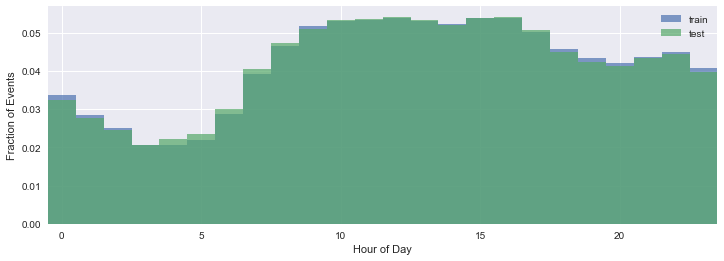

In [91] used 104.023 MiB RAM in 0.775s, peaked 27.961 MiB above current, total RAM usage 1569.969 MiB


In [91]:
test["hour"] = (test.timestamp // (3600 * 1000)) % 24
test["day"] = test.timestamp // (3600 * 24 * 1000)

train["hour"] = (train.timestamp // (3600 * 1000)) % 24
train["day"] = train.timestamp // (3600 * 24 * 1000)

plt.figure(figsize=(12,4))
train.hour.hist(bins=np.linspace(-0.5, 23.5, 25), label="train", alpha=0.7, normed=True)
test.hour.hist(bins=np.linspace(-0.5, 23.5, 25), label="test", alpha=0.7, normed=True)
plt.xlim(-0.5, 23.5)
plt.legend(loc="best")
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")

The time-distribution of clicks appears consistent with the majority of the dataset being in UTC-4 to UTC-6. There appears to be a slight shift from train to test.

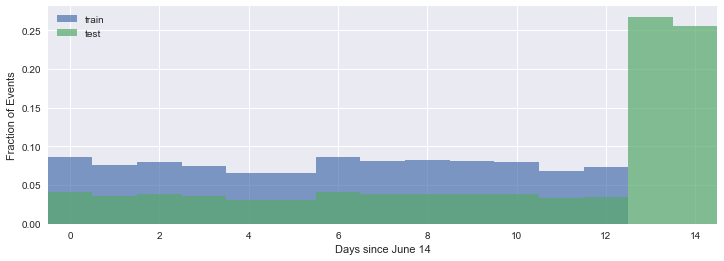

In [92] used 3.945 MiB RAM in 0.391s, peaked 30.230 MiB above current, total RAM usage 1573.914 MiB


In [92]:
plt.figure(figsize=(12,4))
train.day.hist(bins=np.linspace(-.5, 14.5, 16), label="train", alpha=0.7, normed=True)
test.day.hist(bins=np.linspace(-.5, 14.5, 16), label="test", alpha=0.7, normed=True)
plt.xlim(-0.5, 14.5)
plt.legend(loc="best")
plt.xlabel("Days since June 14")
plt.ylabel("Fraction of Events")

Now we can see the very interesting time-based train/test split. About half of the test data is sampled from the same time as the train set, with another half sampled from the two days immediately following.

Next for a more detailed look at the distribution of the training data. Note again that no timezone correction has been applied, but 80% of the data are from the US.

In [ ]:
plt.figure(figsize=(12,6))
hour_day_counts = train.groupby(["hour", "day"]).count().ad_id.values.reshape(24,-1)
# plot 2d hist in days and hours, with each day normalised to 1 
plt.imshow((hour_day_counts / hour_day_counts.sum(axis=0)).T,
           interpolation="none", cmap="rainbow")
plt.xlabel("Hour of Day")
plt.ylabel("Days since June 14")

#### There is something certain files missed from my laptop so it cannot appear properly rightnow, but it worked well before so I took a screenshot below shows the result of the visualization:

<img src="../notebooks/figure1.png" />

The weekend (days 4, 5 and 11 and 12) looks noticeably different from the weekdays -- greater proportion of late-night activity, no real peak in the early afternoon.

In [ ]:
# for completeness, the test set too:
plt.figure(figsize=(12,6))
hour_day_counts = test.groupby(["hour", "day"]).count().ad_id.values.reshape(24,-1)
# plot 2d hist in days and hours, with each day normalised to 1 
plt.imshow((hour_day_counts / hour_day_counts.sum(axis=0)).T,
           interpolation="none", cmap="rainbow")
plt.xlabel("Hour of Day")
plt.ylabel("Days since June 14")

#### There is something certain files missed from my laptop so it cannot appear properly rightnow, but it worked well before so I took a screenshot below shows the result of the visualization:

<img src="../notebooks/figure2.png" />

### Chance of Outbrain Ads


**We are going to unleash the hidden secrets immersed within the data by analyzing and visualize it**

What's the frequency Vs the mean of each AD

clicks_train = pd.read_csv('../datasets/clicks_train.csv')
clicks_test  = pd.read_csv('../datasets/clicks_test.csv')
ads_freq = clicks_train['ad_id'].value_counts()
ads_clicked = clicks_train[clicks_train['clicked'] == 1]['ad_id'].value_counts()
ads_average = ads_clicked.values / ads_freq[ads_clicked.index]

In [27]:
ads_freq = df_train['ad_id'].value_counts()
ads_clicked = df_train[df_train['clicked'] == 1]['ad_id'].value_counts()
ads_average = ads_clicked.values / ads_freq[ads_clicked.index]

#Given the number of clicks for each ad
#We can show the important, the max and the min values
#This gives a clue about how values(count of clicks) is distributed
#For me, I would guess probably it's normally distributed, but, let's see

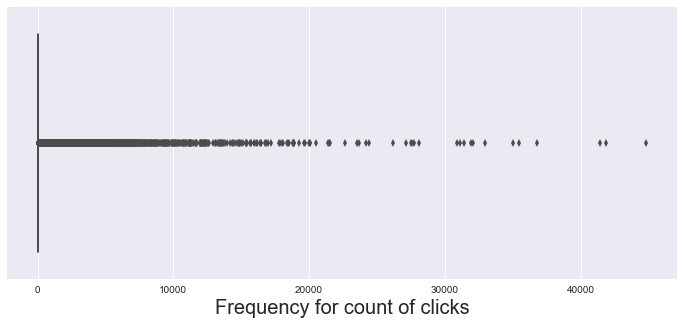

In [28]:
# Plot max, min values, & 2nd, 3rd quartile
fig, (axis1) = plt.subplots(1,1,figsize=(12,5))
sns.boxplot([ads_clicked], ax=axis1)
#axis1.set(xlabel='Frequency for count of clicks',fontsize=15)
plt.xlabel('Frequency for count of clicks', fontsize=20)

From the graph above we can see that 
Huummm, It seems most of the ad clicks lies between 1 and 10000,  and few of them lies after 10000, Isn't it? But, this doesn't clearly show the frequency for ad clicks . The frequency for count of clicks stops at almost 45000 click,

Plot frequency for clicks on ads.

And because there are many values(small) that just appeared a few times, and few values(large) that appeared so much,thus, we had to use Log to show all of them.

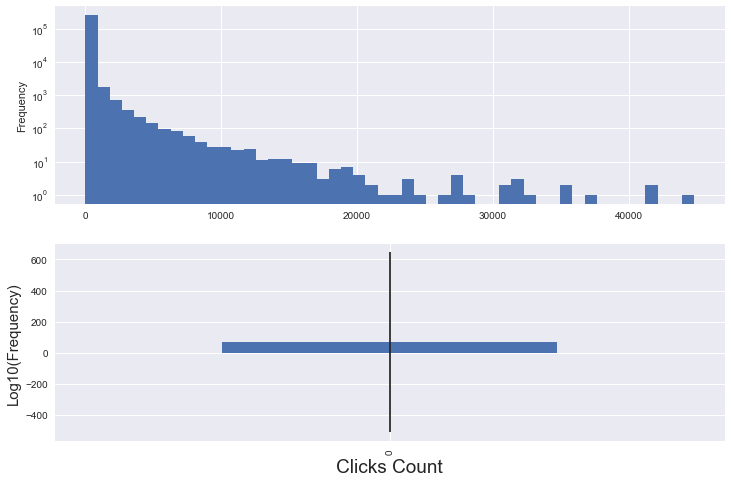

In [29]:
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(12,8))
ads_clicked.plot(kind='hist',bins=50,log=True,ax=axis1)
plt.ylabel('Log10(Frequency)', fontsize=15)
plt.xlabel('Clicks Count', fontsize=19)

# Plot the average of clicks and the standard deviation
# This is a huge std!. According to the empirical rule (given mean=66 & std=578):
# 68% of the clicks where between 66 - 578 and 66 + 578 clicks.
# 95% of the clicks where between 66 - 2 X (578) and 66 + 2 X (578) clicks.
# 98% of the clicks where between 66 - 3 X (578) and 66 + 3 X (578) clicks.
Series(ads_clicked.mean()).plot(yerr=ads_clicked.std(),kind='bar',legend=False, ax=axis2)

**Now we will explore the percentage of ads that were clicked less than(or equal) X times**

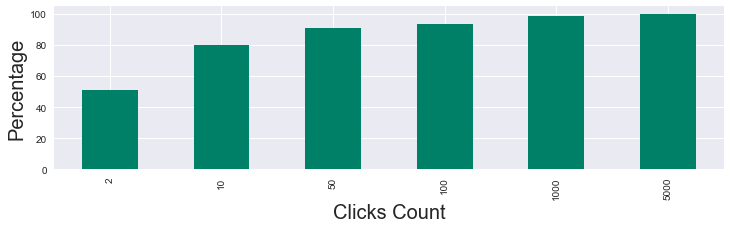

In [30]:
ads_perc = Series()
for i in [2, 10, 50, 100, 1000, 5000]:
    ads_perc[str(i)] = round((ads_clicked.values <= i).mean() * 100, 2)

ax = ads_perc.plot(kind='bar', figsize=(12,3), colormap="summer")
plt.ylabel('Percentage', fontsize=20)
plt.xlabel('Clicks Count', fontsize=20)

while there is a good presence for the freqeuncy for count of views after.
now we will see the actual clicks VS views

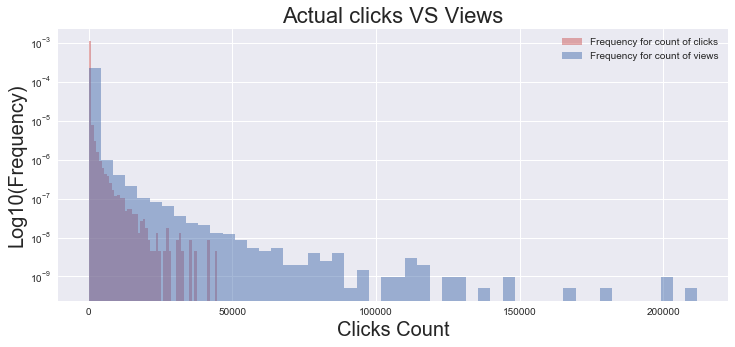

In [31]:
fig, (axis1) = plt.subplots(1,1,figsize=(12,5))

ads_clicked.name = 'Frequency for count of clicks'
ads_freq.name =  'Frequency for count of views'

ads_clicked.plot(kind='hist',bins=50,normed=True,log=True,color='indianred',alpha=0.5,legend=True)
ads_freq.plot(kind='hist',bins=50,normed=True,log=True,alpha=0.5,legend=True)
#axis1.set(ylabel='Log10(Frequency)', xlabel='Count of Clicks')

plt.title('Actual clicks VS Views', fontsize=22)
plt.ylabel('Log10(Frequency)', fontsize=20)
plt.xlabel('Clicks Count', fontsize=20)

## V. Classification & Modelling

In [36]:
#load events, clicks_train, promoted_content and page_views_sample csv's
events_df = pd.read_csv(filedir+'events.csv', nrows=N_ROWS)
promoted_content_df = pd.read_csv(filedir+'promoted_content.csv', nrows=N_ROWS)
promoted_content_df = promoted_content_df.rename(columns={'document_id': 'ad_document_id'})
clicks_train_df = pd.read_csv(filedir+'clicks_train.csv', nrows=N_ROWS)
page_views_sample_df = pd.read_csv(filedir+'page_views_sample.csv', usecols=['uuid','document_id', 'timestamp', 'traffic_source'], nrows=N_ROWS)

In [37]:
#merge events and clicks_train on display_id value
#in order to find what ad was clicked for each event/display_id
#this links platform and geo_location data to each ad that was clicked
events_x_clicks_train_df = pd.merge(events_df, clicks_train_df, on='display_id', how='outer').dropna()
print(events_x_clicks_train_df)

        display_id            uuid  document_id  timestamp platform  \
0                1  cb8c55702adb93       379743         61        3   
1                1  cb8c55702adb93       379743         61        3   
2                1  cb8c55702adb93       379743         61        3   
3                1  cb8c55702adb93       379743         61        3   
4                1  cb8c55702adb93       379743         61        3   
5                1  cb8c55702adb93       379743         61        3   
6                2  79a85fa78311b9      1794259         81        2   
7                2  79a85fa78311b9      1794259         81        2   
8                2  79a85fa78311b9      1794259         81        2   
9                2  79a85fa78311b9      1794259         81        2   
10               3  822932ce3d8757      1179111        182        2   
11               3  822932ce3d8757      1179111        182        2   
12               3  822932ce3d8757      1179111        182        2   
13    

In [38]:
#convert geo_location to int data
events_x_clicks_train_df['geo_location'] = events_x_clicks_train_df['geo_location'].replace('[^0-9]', '', regex=True).replace('', np.nan, regex=True)
pd.to_numeric(events_x_clicks_train_df['geo_location'])

0         519.0
1         519.0
2         519.0
3         519.0
4         519.0
5         519.0
6         807.0
7         807.0
8         807.0
9         807.0
10        505.0
11        505.0
12        505.0
13        505.0
14        505.0
15        505.0
16        564.0
17        564.0
18        564.0
19        564.0
20        564.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26        510.0
27        510.0
28        510.0
29        510.0
          ...  
999970     28.0
999971     28.0
999972     28.0
999973     28.0
999974     40.0
999975     40.0
999976     40.0
999977     40.0
999978     40.0
999979     40.0
999980    533.0
999981    533.0
999982    533.0
999983      NaN
999984      NaN
999985      NaN
999986      NaN
999987      NaN
999988    819.0
999989    819.0
999990    819.0
999991    819.0
999992    567.0
999993    567.0
999994    567.0
999995    567.0
999996    567.0
999997      8.0
999998      8.0
999999      8.0
Name: geo_location, Leng

In [39]:
#merge previous with page_views on uuid and document_id
#in order to find traffic source for each event/display_id
all_available_data_for_each_event = pd.merge(events_x_clicks_train_df, page_views_sample_df, on=['uuid', 'document_id','timestamp'])
all_available_data_for_each_event = pd.merge(all_available_data_for_each_event, promoted_content_df, on='ad_id', how='outer').dropna()
all_available_data_for_each_event = all_available_data_for_each_event.sort_values(by='display_id')
#print(all_available_data_for_each_event)

X = all_available_data_for_each_event[['display_id', 'document_id', 'timestamp', 'platform', 'geo_location', 'ad_id', 'traffic_source', 'ad_document_id', 'campaign_id', 'advertiser_id']]
y = all_available_data_for_each_event[['clicked']]

#rectify timestamp column and convert to hour of day clicked
pd.to_numeric(X['timestamp'])
X['true_time'] = X['timestamp']+1465876799998
X['date'] = pd.to_datetime(X['true_time'], unit='ms')
X['hour'] = X['date'].apply(lambda x: x.strftime('%H'))
X = X.drop('date', axis=1)
X = X.drop('timestamp', axis=1)
X = X.drop('true_time', axis=1)

C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [40]:
#get platform & traffic source columns
X['platform'] = X['platform'].astype(str).convert_objects(convert_numeric=True)
X['traffic_source'] = X['traffic_source'].astype(str).convert_objects(convert_numeric=True)
X['traffic_source'] = X['traffic_source'].astype(int)

# Get one hot encoding of columns geo_location, platform, hour, advertiser_id, and traffic_source
# Drop column as it is now encoded, then drop irrelevant columns
X = X.join(pd.get_dummies(X['platform'], prefix='pl_'))
X = X.drop('platform', axis=1)
X = X.join(pd.get_dummies(X['geo_location'], prefix='ge_'))
X = X.drop('geo_location', axis=1)
X = X.join(pd.get_dummies(X['advertiser_id'], prefix='ad_'))
X = X.drop('advertiser_id', axis=1)
X = X.join(pd.get_dummies(X['hour'], prefix='hr_'))
X = X.drop('hour', axis=1)
X = X.join(pd.get_dummies(X['traffic_source'], prefix='ts_'))
X = X.drop('traffic_source', axis=1)

#X = X.join(pd.get_dummies(X['campaign_id']))
X = X.drop('campaign_id', axis=1)
X = X.drop('ad_id', axis=1)
X = X.drop('document_id', axis=1)
X = X.drop('ad_document_id', axis=1)
X = X.drop('display_id', axis=1)

C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


After setting all the algorithms up, now we will explore fitting different classifiers:

Firstly, we will try **Decision Trees**

In [41]:
clf = tree.DecisionTreeClassifier() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.762359063313


How about **Logistic Regression**?

In [42]:
clf = linear_model.LogisticRegression(solver='sag', multi_class='ovr') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

C:\Users\feiya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.826539462272


In [43]:
clf = linear_model.LogisticRegressionCV(Cs=100, fit_intercept=True, cv=None, dual=False, penalty='l2', solver='liblinear', tol=0.0001, max_iter=1000, refit=True, multi_class='ovr')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.825672159584


And **SGD Classifier**?

In [44]:
clf = linear_model.SGDClassifier() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.776235906331


Ensemble? Try **Random Forest**?

In [45]:
clf = ensemble.RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=20, 
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                      max_leaf_nodes=None, min_impurity_split=1e-02, bootstrap=True, class_weight=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.810060711188


Looks good, how about different kinds of **SVC (Support Vector Machine)**?

In [46]:
clf_svn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape=None, degree=3, 
              gamma='auto', kernel='rbf',max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.8091934085


In [47]:
clf = svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=0.00001, C=1.0, multi_class='crammer_singer', 
                    fit_intercept=False, intercept_scaling=1, max_iter=2000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.811795316565


Let's go for **Passive Aggressive** Classifier for a try?

In [48]:
clf = linear_model.PassiveAggressiveClassifier(C=1.0, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, 
                                               loss='hinge', n_jobs=1, random_state=None, warm_start=False, class_weight=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.738074588031


How about **k-nearest neighbours (kNN)**?

In [49]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                     metric='minkowski', metric_params=None, n_jobs=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

C:\Users\feiya\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.79618386817


Finally, we cannot forget **AdaBoost**!

In [50]:
clf = ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', 
                                  random_state=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.830875975716


In [51]:
np.set_printoptions(threshold=np.nan)
#print(clf.predict(X_test))
#print(y_test)
print(metrics.f1_score(y_test, clf.predict(X_test)))

0.190871369295


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(metrics.f1_score(y_test, clf.predict(X_test)))

0.82774566474
0.207446808511


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(metrics.f1_score(y_test, clf.predict(X_test)))

0.816131830009
0.217712177122


Now, let's generate a simple plot of the test and training learning curve.

Here are some desciption of the variables:

**estimator** stands for the object implements the "fit" and "predict" methods.

**cv** stands for cross-validation generator or and iterable. It determines the cross-validation splitting strategy.


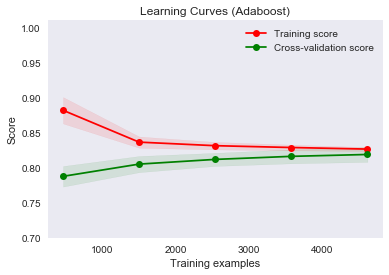

<module 'matplotlib.pyplot' from 'C:\Users\feiya\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [55]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()
    return plt

title = "Learning Curves (Adaboost)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cvx = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
y = y.as_matrix().ravel()
#y = y.ravel()
plot_learning_curve(clf, title, X.as_matrix(), y, ylim=(0.7, 1.01), cv=cvx, n_jobs=4)

Now let's try the SVM, which performed well too.

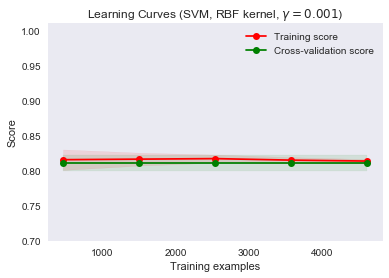

<module 'matplotlib.pyplot' from 'C:\Users\feiya\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

In [56]:
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svm.SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

## VI. More Feature Engineering (Combined with Hadoop)

As we already performed many feature engineering using Hadoop (Spark and Hive), here we will just pick some interesting part and visulize the content which we cannot use matlabplot to visulize using PySpark.

Now we will import the dataset:

In [57]:
page_views_sample_df = pd.read_csv(filedir+'page_views_sample.csv', usecols=['uuid','document_id', 'timestamp', 'traffic_source', 'platform'], nrows=N_ROWS)

In [58]:
page_views_docid = page_views_sample_df['document_id'].value_counts()


Similar result came out shows the popular documents which got many clicks from users.

In [59]:
page_views_docid_df = pd.DataFrame(page_views_docid)
page_views_docid_df.head(10)

,document_id
42744,156231
1790442,91420
732651,74630
25792,72078
1770064,63370
468335,57584
1669669,16858
1586626,10813
199999,10309
399196,10266


How about the platform and traffic source data? Let's explore them:

In [60]:
page_views_pf = page_views_sample_df['platform'].value_counts()
page_views_pf_df = pd.DataFrame(page_views_pf)
page_views_pf_df

,platform
2,450526
1,446894
3,102580


Nice! So let's draw a pie chart to see how these three distribute:

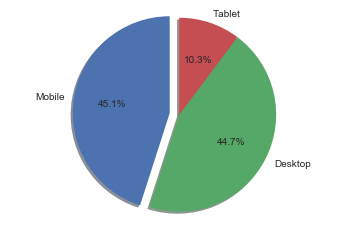

In [61]:
explode = (0.1, 0.0, 0)
labels = 'Mobile', 'Desktop', 'Tablet'
fig1, ax1 = plt.subplots()
ax1.pie(page_views_pf_df, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figure(figsize=(12, 6))
plt.show()

Obviously, the same as Spark gave us, Mobile is the most popular followed by Desktop.

In [62]:
page_views_ts = page_views_sample_df['traffic_source'].value_counts()
page_views_ts_df = pd.DataFrame(page_views_ts)
page_views_ts_df

,traffic_source
1,630924
3,202625
2,166451


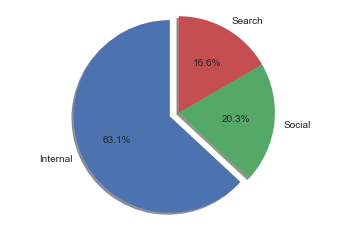

In [63]:
explode = (0.1, 0.0, 0)
labels = 'Internal', 'Social', 'Search'
fig1, ax1 = plt.subplots()
ax1.pie(page_views_ts_df, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.figure(figsize=(12, 6))
plt.show()

Lovely pie chart! Very clearly shows that internal plays a big role in the three traffic sources.

### Regional Data Exploration

I used Hive to extract a new dataset which includes binary varibles to indicate if the row is from a specific country or not. In this case, I picked four countries from four regions: US from America, Korea from Asia, France from Europe and South Africa from Africa. Let's see how they can give us here in Jupyter:

In [64]:
page_views_geo = pd.read_csv('../datasets/page_views_sample_geo.csv')
page_views_geo.head(5)

,uuid,document_id,timestamp,platform,geo_location,traffic_source,uscount,frcount,krcount,sacount
0,1fd5f051fba643,120,31905835,1,RS,2,0,0,0,0
1,8557aa9004be3b,120,32053104,1,VN>44,2,0,0,0,0
2,c351b277a358f0,120,54013023,1,KR>12,1,0,0,1,0
3,8205775c5387f9,120,44196592,1,IN>16,2,0,0,0,0
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2,1,0,0,0


Same result came out as Spark:

In [65]:
print("US user count:")
print sum(page_views_geo['uscount'])
print("French user count:")
print sum(page_views_geo['frcount'])
print("Korean user count:")
print sum(page_views_geo['krcount'])
print("South African user count:")
print sum(page_views_geo['sacount'])

US user count:
234794
French user count:
213
Korean user count:
154
South African user count:
116


US users still play a big role in the global internet market!

In [66]:
geo_user = [{'country': 'United States', 'count': 234794},
                 {'country': 'France', 'count': 213},
                 {'country': 'Korea', 'count': 154},
                 {'country': 'South Africa', 'count': 116}]
geo_user_count = pd.DataFrame(geo_user)
geo_user_count

,count,country
0,234794,United States
1,213,France
2,154,Korea
3,116,South Africa


Now, let's split the dataset into four smaller ones which represents a specific country:

In [67]:
usclick = (page_views_geo.loc[page_views_geo['uscount'] == 1])
frclick = (page_views_geo.loc[page_views_geo['frcount'] == 1])
krclick = (page_views_geo.loc[page_views_geo['krcount'] == 1])
saclick = (page_views_geo.loc[page_views_geo['sacount'] == 1])

Interesting! The top 3 popular document in US are 42744, 25792 and 53430. 

The global top 3 are 42744, 1790442, 732651. Which has the same No.1 as US but the 2nd and 3rd are out of US's top 10!

In [68]:
us_doc = usclick['document_id'].value_counts()
us_doc_pd = pd.DataFrame(us_doc)

In [69]:
print ("US users document distribution:")
print us_doc_pd.head(10)

US users document distribution:
       document_id
42744       155330
25792        62048
53430         3575
87488         1171
78535          783
92817          694
10653          382
7012           369
60040          332
93106          296


In [70]:
us_count = [{'document_id': '42744', 'count': 155330},
            {'document_id': '25792', 'count': 62048},
            {'document_id': '53430', 'count': 3575},
            {'document_id': '87488', 'count': 1171},
           {'document_id': '78535', 'count': 783},
           {'document_id': '92817', 'count': 694},
           {'document_id': '10653', 'count': 382},
           {'document_id': '7012', 'count': 369},
           {'document_id': '60040', 'count': 332},
           {'document_id': '93106', 'count': 296}]
us_count_df = pd.DataFrame(us_count)
us_count_df

,count,document_id
0,155330,42744
1,62048,25792
2,3575,53430
3,1171,87488
4,783,78535
5,694,92817
6,382,10653
7,369,7012
8,332,60040
9,296,93106


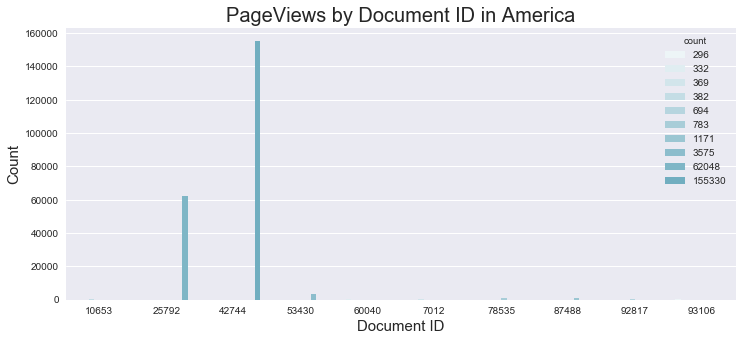

In [71]:
plt.figure(figsize=(12, 5))
sns.barplot(us_count_df['document_id'], us_count_df['count'], us_count_df['count'], alpha=1, color=p[5])
plt.title('PageViews by Document ID in America', fontsize=20)
plt.xlabel('Document ID', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

Now let's have a look with French people!

In [72]:
fr_doc = frclick['document_id'].value_counts()
fr_doc_pd = pd.DataFrame(fr_doc)
print ("French users document distribution:")
print fr_doc_pd.head(10)

French users document distribution:
       document_id
25792          132
42744           19
25529            5
86498            5
7012             5
25345            3
78535            3
53430            3
58670            2
48785            2


Interesting! The top 3 popular document in US are 25792, 42744 and 25529. Very close to the US! 42744 document is still very popular in France! 

In [73]:
kr_doc = krclick['document_id'].value_counts()
kr_doc_pd = pd.DataFrame(kr_doc)
print ("Korean users document distribution:")
print kr_doc_pd.head(10)

Korean users document distribution:
       document_id
25792          128
42744            7
83316            3
7012             3
25529            2
87488            2
32764            1
53430            1
40628            1
82587            1


It is fun to see that Asia is getting closer to the Western world. 25792 and 42744 are top 2 in Korea also in US and France as well.And US 3rd 53430 is still top 10 in Korea!

In [74]:
sa_doc = saclick['document_id'].value_counts()
sa_doc_pd = pd.DataFrame(sa_doc)
print ("South African users document distribution:")
print sa_doc_pd.head(10)

South African users document distribution:
        document_id
25792            70
87488             9
106267            5
984               3
49464             3
42744             3
78535             3
58670             2
44063             2
102424            2


Things get a little different here in SA! Although 25792 is still the No.1, the other popular documents here seem not like that popular in other countries like France and Korea. 

There are more comparisons and data digging in our Zeppelin Notebook! It is very interesting to read and try to understand all the data, make sense of them :)

## VIII. Bigish Data Handling (beta tested did not used)

We tried to use the bigish data handling methods introduced in Lecture 1, it works very well but for convenience, we abandoned this and used the smaller sample dataset instead. We will show the code snippets here to show our works.

We now have a Bigish Data set that cannot fit into our System/Memory, but we can convert into an HDF5 format. Moreover, we can read into memory only portions of it that are of interest to us an to our immediate processing needs

In [75]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()
import datetime as dt

In [75] used 0.000 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 7661.438 MiB


In [76]:
df = pd.read_csv('../datasets/clicks_test.csv', infer_datetime_format=True)
df.head()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


In [76] used 492.961 MiB RAM in 6.915s, peaked 219.344 MiB above current, total RAM usage 8154.398 MiB


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32225162 entries, 0 to 32225161
Data columns (total 2 columns):
display_id    int64
ad_id         int64
dtypes: int64(2)
memory usage: 491.7 MB
In [77] used 0.008 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 8154.406 MiB


In [78]:
#We will consider looping through a dataframe that has 1M rows.
def dataframe_access_using_iat(df):
    for i in range(len(df)):
        df.iat[i, 0]
        
%time dataframe_access_using_iat(df[:1000000])

Wall time: 5.7 s
In [78] used 19.645 MiB RAM in 5.705s, peaked 7.633 MiB above current, total RAM usage 8174.051 MiB


In [79]:
def dataframe_access_using_at(df):
    for i in range(len(df)):
        df.at[i, 'ad_id']

%time dataframe_access_using_at(df[:1000000])

Wall time: 10.9 s
In [79] used 7.910 MiB RAM in 10.870s, peaked 7.633 MiB above current, total RAM usage 8181.961 MiB


** If we would not have Hive for this project ,we could have use HDF5 Technology for  this Bigish Dataset**

When we work with a Big Data set , don't have HIVE Platform, this is one of the best platform to handel Bigish data. This HDF 5 convert and store them in a binary format like HDF5 (Hierarchical Data Format).
It is a multipurpose hierarchical container format capable of storing large numerical datasets with their metadata

In [80]:
%time df.to_hdf('../datasets/clicks_test.h5', '/data', format='table', mode='w', data_columns=['ad_id'])

Wall time: 43.5 s
In [80] used 264.461 MiB RAM in 43.532s, peaked 469.453 MiB above current, total RAM usage 8446.422 MiB


In [81]:
hdf = pd.HDFStore('../datasets/clicks_test.h5')
hdf

<class 'pandas.io.pytables.HDFStore'>
File path: ../datasets/clicks_test.h5
/data            frame_table  (typ->appendable,nrows->32225162,ncols->2,indexers->[index],dc->[ad_id])

In [81] used 0.066 MiB RAM in 0.033s, peaked 0.000 MiB above current, total RAM usage 8446.488 MiB


In [82]:
hdf['/data'].shape

(32225162, 2)

In [82] used 737.566 MiB RAM in 0.672s, peaked 418.250 MiB above current, total RAM usage 9184.055 MiB


In [83]:
hdf.put('tables/t1', pd.DataFrame(np.random.rand(20,5)))
hdf.put('tables/t2', pd.DataFrame(np.random.rand(10,3)))
hdf.put('data/t1', pd.DataFrame(np.random.rand(15,2)))
hdf

<class 'pandas.io.pytables.HDFStore'>
File path: ../datasets/clicks_test.h5
/data                 frame_table  (typ->appendable,nrows->32225162,ncols->2,indexers->[index],dc->[ad_id])
/data/t1              frame        (shape->[15,2])                                                         
/tables/t1            frame        (shape->[20,5])                                                         
/tables/t2            frame        (shape->[10,3])                                                         

In [83] used -737.539 MiB RAM in 0.157s, peaked 737.559 MiB above current, total RAM usage 8446.516 MiB


In [84]:
# Time to close the HDF
hdf.close()

In [84] used -0.039 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 8446.477 MiB


In [ ]:
df = pd.read_hdf('../datasets/clicks_test.h5', '/data',columns=['display_id','ad_id'], where='ad_id > 1694')
df.head()

## VIII. Submission

Here we tried different numbers of regularization, we found that 10 gets a better score than 20 (slightly different, about 0.005 differences). 

In [86]:
reg = 10
#reg = 20

train = pd.read_csv("../datasets/clicks_train.csv")

cnt = train[train.clicked==1].ad_id.value_counts()
cntall = train.ad_id.value_counts()

def get_prob(k):
    if k not in cnt:
        return 0
    return cnt[k] / (float(cntall[k]) + reg)

def srt(x):
    ad_ids = map(int, x.split())
    ad_ids = sorted(ad_ids, key=get_prob, reverse=True)
    return " ".join(map(str,ad_ids))
   
subm = pd.read_csv("../datasets/sample_submission.csv") 
subm['ad_id'] = subm.ad_id.apply(lambda x: srt(x))
subm.to_csv("submission_fran&mab_reg10.csv", index=False)
#subm.to_csv("submission_fran&mab_reg20.csv", index=False)

In [86] used -2834.398 MiB RAM in 925.780s, peaked 6760.070 MiB above current, total RAM usage 3443.039 MiB


We finally got 0.63537 as our submission score. Here is the screenshot from Kaggle:

<img src="../notebooks/result.jpg" />

## IX. Presentation link

Presentation Link: https://prezi.com/view/8e32KpnAeZ42cKUZoo3g/